<a href="https://colab.research.google.com/github/keqiu1898/final-project/blob/main/model_training_and_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Skin Lesion Backgroud**

    A biopsy with a thorough pathological examination is the gold standard for determining if a suspicious mole is cancerous. However, biopsies are not always needed or appropriate due to the associated costs or preexisting conditions that make healing more difficult. It is especially true for sensitive areas like the face or ears. Biopsies can also cause undue stress and anxiety for patients and their loved ones.
    
    Due to these concerns, we are turning to non-invasive techniques that can give us helpful information instead of – or before – a traditional biopsy. We built a model that automatically classifies skin images into eleven categories: five benign skin lesions - nevus; keratosis including seborrheic keratosis, pigmented benign keratosis, lichenoid keratosis; lentigo including solar lentigo, lentigo NOS, and lentigo simplex; dermatofibroma and all the other benign skin lesion like scars, angioma, neurofibroma, verruca, acrochordon, etc. included in the category named other benign skin lesions. Three skin cancers: melanoma, basal cell carcinoma, and squamous cell carcinoma. Three indeterminate skin lesions are called actinic keratosis, vascular lesion, and all other indeterminate skin lesions. Our model requests users to upload a clear skin lesion image to make our classification more accurate. The training data are from ISIC. It is challenging owing to the fine-grained variability in the appearance of skin lesions. Luckily, our model works well using a search tree combined with convolutional neural networks.

# **The Seaching Tree**


  **step 1:**
  
     Checking whether a uploaded images is valid or not:
          Valid image for next step
          Invalid image, asking for reload

  **Step 2:** 

     Classify Skin Lesions - Determinate and Indetermiate 
     The indeterminate skin lesion includes Actinic Keratosis, Vascular Lesion, Atypical melanocyic profiferation, and AIMP which might turn into cancerous (malignant) or benign.
     The determinate skin lesion included benign and malignant (cancerous) skin lesion.


    An excision biopsy is required for an indeterminate diagnosis. We would require users to visit their physicians to get more information about their skin lesions.
     


**Step 3:** 

     Classify Determinate Skin Cancer into two categories:
          Benign Skin lesion
          Skin Cancer (malignant)

    
**Step 4 - 1:**

        Classify Benign skin lesion into four categories: 
        nevus,
        keratosis (including seborrheic keratosis pigmented benign keratosis, lichenoid keratosis),
        lentigo (including solar lentigo, lentigo NOS, lentigo simplex),
        dermatofibroma,
        and others (including scars, angioma, neurofibroma, others, verruca, acrochordon, etc)


**Step 4-2:**

        Classify Skin Cancers into three categories:        
        melanoma,
        basal cell carcinoma(BCC),
        squamous cell carcinoma (SCC)


**Step 4-3:**

        Classify Indeterminate Skin Lesion into three categories:        
        Actinic Keretosis,
        Vascular Lesion,
        and others (including Aytical Melanocytic Proliferation, AIMP, etc)


# **Preparation**

### **Python libraries**

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11)


from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import itertools
import shutil

import tensorflow as tf
import tensorflow.keras as keras
from keras.utils.np_utils import to_categorical  # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet import ResNet
from keras.metrics import categorical_crossentropy


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
%cd /content/gdrive/MyDrive/ColabNotebooks/lastversionskincancer/
tf.config.list_physical_devices('GPU')

### **A series of models**

First of all, we create four CNNs that we would be used in the next section.


**Simplebuild Model**: the first layer of Simplebuild is convolution layer performs convolute with input image followed by Activation (ReLU) layer, MaxPooling layer,Normalization layer, Fattern layer, Fully connected layer followed by Sigmoid as Activiation Function layer.

To calculate loss function, we use binary cross entropy which calculates the average measure of difference between two probability distribution for random events. Binary cross entropy is followed by the Sigmoid activation function. 

There are four different optimizers can be choosed: Adam, RmsProp, SGD, Nadam


In [ ]:
def Simplebuild(input_shape= (40,40,3), lr = 1e-4, num_classes= 2, 
          init= 'glorot_uniform', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(11, 11),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform', strides = 2,  use_bias=True))
    
    model.add(MaxPool2D(pool_size = (8, 8) , strides = 2))
    model.add(BatchNormalization()) 
    model.add(Flatten())       
    model.add(Dense(num_classes, activation='sigmoid', kernel_initializer=init, use_bias=True))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    
    elif optim == 'SGD':
         optimizer = SGD(learning_rate=lr)
         
    elif optim == 'Nadam':   
         optimizer = Nadam(learning_rate=lr)

    else:
        optimizer = Adam(learning_rate=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model


**Build Model**: the Build model is a little bit complex than the Simplebuild model.  A convolution layer followed by activation function and a MaxPooling layer are repeated three times in Build model. It then is followed a Fattern layer, a Fully connected layer and a Sigmoid Activiation Function layer.

Loss function is still binary cross entropy. 

There are also four different optimizers can be choosed: Adam, RmsProp, SGD, Nadam

In [ ]:
def build(input_shape= (128,128,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(11, 11),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform' , use_bias=True))
    model.add(MaxPool2D(pool_size = (3, 3)))
    #model.add(Dropout(0.5))

    model.add(Conv2D(32, kernel_size=(5, 5),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform' , use_bias=True))
    model.add(MaxPool2D(pool_size = (3, 3)))
    #model.add(Dropout(0.5))
    
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform' , use_bias=True))
    model.add(MaxPool2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='sigmoid', kernel_initializer=init , use_bias=True))
    model.summary()


    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    
    elif optim == 'SGD':
         optimizer = SGD(learning_rate=lr)
         
    elif optim == 'Nadam':   
         optimizer = Nadam(learning_rate=lr)

    else:
        optimizer = Adam(learning_rate=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

**Complexbuild Model**: the Build model is a little bit complex than the build model.  A convolution layer followed by activation function, a MaxPooling layer, and a Dropout layer are repeated seven times in Complexbuild model. It then is followed a Fattern layer, a Fully connected layer and a Sigmoid Activiation Function layer.

Loss function is still binary cross entropy. 

There are also four different optimizers can be choosed: Adam, RmsProp, SGD, Nadam

In [ ]:
def Complexbuild(input_shape= (128,128,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(11, 11),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform' , use_bias=True))
    model.add(MaxPool2D(pool_size = (3, 3)))
    model.add(Dropout(0.5))

    model.add(Conv2D(32, kernel_size=(5, 5),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform' , use_bias=True))
    model.add(MaxPool2D(pool_size = (3, 3)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform' , use_bias=True))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform' , use_bias=True))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform' , use_bias=True))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform' , use_bias=True))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform' , use_bias=True))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='sigmoid', kernel_initializer=init , use_bias=True))
    model.summary()


    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    
    elif optim == 'SGD':
         optimizer = SGD(learning_rate=lr)
         
    elif optim == 'Nadam':   
         optimizer = Nadam(learning_rate=lr)

    else:
        optimizer = Adam(learning_rate=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

**AlexNet Model:** The architecture consists of eight layers: five convolutional layers, five normalization layers, three MaxPooling layers, four Dropout layer,  and three fully-connected layers.

In [ ]:

def AlexNet(input_shape= (150,150,3), lr = 1e-4, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(11, 11),strides=(4,4), padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='RandomUniform', use_bias=True))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2, 2)))    
    model.add(Dropout(0.5))

    model.add(Conv2D(256, kernel_size=(5, 5),padding = 'Same', 
                     activation =activ, kernel_initializer = 'RandomUniform', use_bias=True)
             )
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3, 3)))
    model.add(Dropout(0.5))
    
    
    model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform',  use_bias=True) )
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(256, kernel_size=(1, 1),padding = 'Same', 
                     activation = activ, kernel_initializer = 'glorot_uniform', use_bias=True)
                      )
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(256, kernel_size=(1, 1),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform', use_bias=True
                    )
             )
    model.add(BatchNormalization())    
    model.add(MaxPool2D(pool_size = (2, 2)))
    
    model.add(Flatten())    
    model.add(Dense(1024, activation='relu', kernel_initializer=init, use_bias=True))
    model.add(Dropout(0.5))
    
    model.add(Dense(1024, activation='relu', kernel_initializer=init , use_bias=True
                   )
             )
    model.add(Dropout(0.5))  
    
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=init , use_bias=True
                   )
             )
    model.summary()


    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    
    elif optim == 'SGD':
         optimizer = SGD(learning_rate=lr)
         
    elif optim == 'Nadam':   
         optimizer = Nadam(learning_rate=lr)

    else:
        optimizer = Adam(learning_rate=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model




### **Data Uploding and Converting**
The images of skin lesions are taken from the ISIC (International Skin Image Collaboration) Archive. The pictures have all been resized to low resolution (250x250x3) RGB.

In [ ]:
newsize = (250, 250)
read = lambda imname: np.asarray(Image.open(imname).resize(newsize).convert("RGB"))

invalid_path  = 'cancerimage/invalid'
invalid = [read(os.path.join(invalid_path, filename)) for filename in os.listdir(invalid_path) if filename[-3:] == 'JPG']
invalid  = np.array(invalid,  dtype='uint8')
print('invalid')

valid_path  = 'cancerimage/valid'
valid = [read(os.path.join(valid_path, filename)) for filename in os.listdir(valid_path) if filename[-3:] == 'JPG']
valid  = np.array(valid,  dtype='uint8')
print('valid')


benign_path  = 'cancerimage/benign/'
malignant_path  = 'cancerimage/malignant/'
indeterminate_path = 'cancerimage/indeterminate/'


for images in [benign_path, malignant_path, indeterminate_path]:
    for file in os.listdir(images):
        if file[-5:] == 'Store':
            continue
        
        myVars = globals()
        # just read the first 15 pictures
        myVars['ims_'+file] = [read(os.path.join(images+file, filename)) for filename in os.listdir(images+file)[:4000] if filename[-3:] == 'JPG']
        print(file)
        myVars[file]  = np.array(myVars['ims_'+file],  dtype='uint8')

    The original dataset:
    invalid
    valid
    lentigo 
    dermatofibroma
    nevus
    neurofibroma
    keratosis
    basal_cell_carcinoma
    melanoma
    squamous_cell_carcinoma 
    actinic_keratosis
    vascular_lesion
    others

### **Saving Dataset as Numpy DataFrame** **bold text**

In [ ]:
# Load saved array 
np.save('invalid', invalid)
np.save('valid', valid)
# benign skin lesion
np.save('lentigo', lentigo )
np.save('dermatofibroma', dermatofibroma)
np.save('neurofibroma', neurofibroma)
np.save('nevus', nevus)
np.save('keratosis', keratosis)

# malignant skin lesion
np.save('melanoma', melanoma)
np.save('basal_cell_carcinoma', basal_cell_carcinoma)
np.save('squamous_cell_carcinoma', squamous_cell_carcinoma )

# indeterminate skin lesion
np.save('actinic_keratosis', actinic_keratosis)
np.save('vascular_lesion', vascular_lesion)
np.save('others', others )

### **Loading Numpy DataFrame**

In [ ]:
invalid = np.load('4000-250/invalid.npy')
valid = np.load('4000-250/valid.npy')
lentigo = np.load('4000-250/lentigo.npy')
dermatofibroma= np.load('4000-250/dermatofibroma.npy')
neurofibroma = np.load('4000-250/neurofibroma.npy') # all other benign skin lesions are in neurofibroma file
nevus = np.load('4000-250/nevus.npy')
keratosis = np.load('4000-250/keratosis.npy')
melanoma = np.load('4000-250/melanoma.npy')
basal_cell_carcinoma = np.load('4000-250/basal_cell_carcinoma.npy')
squamous_cell_carcinoma = np.load('4000-250/squamous_cell_carcinoma.npy')

actinic_keratosis = np.load('4000-250/actinic_keratosis.npy')
vascular_lesion = np.load('4000-250/vascular_lesion.npy')
others = np.load('4000-250/others.npy')

### **Creating Inputs**

In [ ]:
benign_vars = [lentigo, dermatofibroma, nevus, neurofibroma, keratosis]
malignant_vars = [melanoma, basal_cell_carcinoma, squamous_cell_carcinoma]
determinate_vars = [lentigo, dermatofibroma, nevus, neurofibroma, keratosis, melanoma, basal_cell_carcinoma, squamous_cell_carcinoma]
indeterminate_vars = [actinic_keratosis,  vascular_lesion, others]

benign = np.concatenate(benign_vars, axis = 0)
malignant = np.concatenate(malignant_vars, axis = 0)
determinate = np.concatenate(determinate_vars, axis = 0)
indeterminate = np.concatenate(indeterminate_vars, axis = 0)


# **Step 1: Invalid or Valid**





**classifying a picture as valid or invalid. 0 is invalid and 1 is valid**

## **Creating Corresponding Inputs and Outputs: valid and invalid**

In [ ]:
variables = [invalid, valid] 
for i in range(len(variables)):
    myVars = globals()
    myVars['Y_'+str(i)] = np.repeat(i, len(variables[i]))
    Y_s.append(myVars['Y_'+str(i)])

**Data Merge**

In [ ]:
X = np.concatenate(variables, axis = 0) 
Y = np.concatenate(Y_s, axis= 0) 

**Shuffle data**


 75% of data as training data; 25% data as testing data.

In [ ]:
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=4, stratify=Y)

## **Display first 15 images of moles, and how they are classified.**

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)    
    if Y_train[i] ==0:
        ax.title.set_text('invalid')
    elif Y_train[i] ==1:
        ax.title.set_text('valid')               
    plt.imshow(X_train[i], interpolation='nearest')
    plt.savefig('The fist 15 valid or invalid images')
plt.show()

**Categorical Labels and Normalization**

Turn labels into one hot encoding.

Normalize all Values of the pictures by dividing all the RGB values by 255\
With data augmentation to prevent overfitting 

In [ ]:
y_train = to_categorical(Y_train, num_classes= len(variables))
y_test = to_categorical(Y_test, num_classes= len(variables))
x_train = X_train/255.
x_test = X_test/255.

## **AlexNet with 5,004,290 parameters**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
optim = 'rmsprop'
epochs = 110
batch_size = 30


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

Valid_Invalid_AlexNet = AlexNet(lr = lr, init = init, activ = activ, optim = optim, input_shape = input_shape)


with tf.device('/GPU:0'):
    history_Valid_Invalid_AlexNet = Valid_Invalid_AlexNet.fit(x_train, y_train, validation_split = 0.25,
                    epochs = epochs, batch_size = batch_size,verbose = 2, 
                   callbacks =[learning_rate_reduction])
    
# Save the model
# os.chdir('/')
Valid_Invalid_AlexNet.save('Valid_Invalid_AlexNet')  

In [ ]:
#np.save('history_Valid_Invalid_AlexNet', history_Valid_Invalid_AlexNet.history)
history=np.load('valid_invalid/history_Valid_Invalid_AlexNet.npy',allow_pickle='TRUE').item()

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy for Valid or Invalid Classification')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Valid or Invalid Classification.png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss for Valid or Invalid Classification')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss for Valid or Invalid Classification.png')
plt.show()

### Model Evaluation 

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = Valid_Invalid_AlexNet.evaluate(x_test, y_test)
print("test loss, test acc:", results)


    The accuracy of the testing stage is 82.05% which is greater than 51.63% (=79/(79+74), 79 invalid samples and 74 valid samples)

## **ResNet50**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
optim = 'rmsprop'
epochs = 300
batch_size = 40


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

Valid_Invalid_ResNet = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)


Valid_Invalid_ResNet.compile(optimizer = optim ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])


with tf.device('/GPU:0'):
    history_Valid_Invalid_ResNet = Valid_Invalid_ResNet.fit(x_train, y_train, validation_split=0.25,
                        epochs= epochs, batch_size= batch_size, verbose=2, 
                        callbacks=[learning_rate_reduction]
                       )

# Save the model
# os.chdir('/')
Valid_Invalid_ResNet.save('Valid_Invalid_ResNet')    

In [ ]:
np.save('valid_invalid/history_Valid_Invalid_ResNet', history_Valid_Invalid_ResNet.history)
history=np.load('valid_invalid/history_Valid_Invalid_ResNet.npy',allow_pickle='TRUE').item()

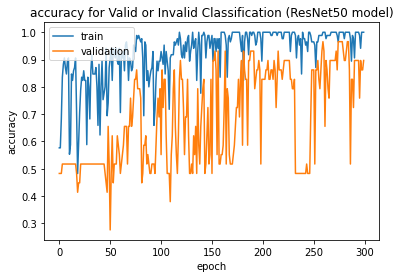

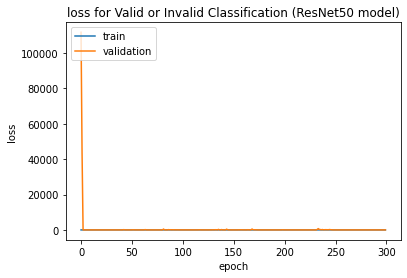

In [ ]:

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('accuracy for Valid or Invalid Classification (ResNet50 model)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Valid or Invalid Classification (ResNet50 model).png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss for Valid or Invalid Classification (ResNet50 model)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss for Valid or Invalid Classification (ResNet50 model).png')
plt.show()



### Model Evaluation

In [ ]:
#Valid_Invalid_ResNet = keras.models.load_model('Valid_Invalid_ResNet')
print("Evaluate on test data")
results = Valid_Invalid_ResNet.evaluate(x_test, y_test)
print("test loss, test acc:", results)


Evaluate on test data
2/2 [==============================] - 0s 16ms/step - loss: 0.4160 - accuracy: 0.8974
test loss, test acc: [0.41603371500968933, 0.8974359035491943]


    The accuracy is 89.74%, a little bit greater than 51%.

## **Conclusion**

    In this part using ResNet60 has overfitting problem, so we pick AlexNet to classfiy valid and invalid images. 

# **Step 2: Indeterminate and Determinate Skin Lesion**



**0 is determinate and 1 is indeterminate.**

## **Creating Inputs and Outputs Sets**

In [ ]:
import random
variables = [determinate[random.sample(range(4000), 400)], indeterminate]
Y_s = []
for i in range(len(variables)):
    myVars = globals()
    myVars['Y_'+str(i)] = np.repeat(i, len(variables[i]))
    Y_s.append(myVars['Y_'+str(i)])

**Data Merge**

In [ ]:

X = np.concatenate(variables, axis = 0)
Y = np.concatenate(Y_s, axis= 0) 
print(indeterminate.shape)
print(X.shape)

(357, 250, 250, 3)
(757, 250, 250, 3)


In [ ]:
#np.save('determinate and indeterminate/determinate_subset', variables[0])
#determinate_subset = np.load('determinate and indeterminate/variables.npy', allow_pickle=True)
#print(determinate_subset.shape)

**Shuffle data**


 75% of data as training data; 25% data as testing data.

In [ ]:
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=4, stratify=Y)

### **Displaying the first 15 images of moles, and their classifications.**

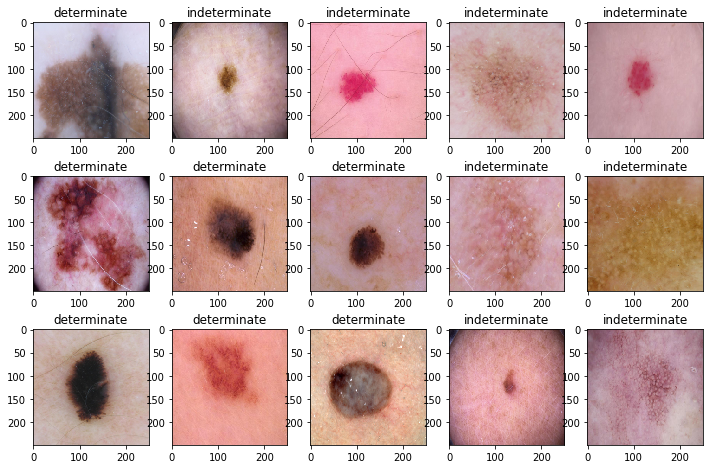

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)    
    if Y_train[i] ==0:
        ax.title.set_text('determinate')
    elif Y_train[i] ==1:
        ax.title.set_text('indeterminate')                
    plt.imshow(X_train[i], interpolation='nearest')
    plt.savefig('The fist 15 images of determinate and indeterminate skin lesions')
plt.show()

**Categorical Labels and Normalization**

Turn labels into one hot encoding.

Normalize all Values of the pictures by dividing all the RGB values by 255\
With data augmentation to prevent overfitting 

In [ ]:
y_train = to_categorical(Y_train, num_classes= len(variables))
y_test = to_categorical(Y_test, num_classes= len(variables))
x_train = X_train/255.
x_test = X_test/255.

## **AlexNet**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
optim = 'rmsprop'
epochs = 120
batch_size = 35


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

Deter_Indeter_AlexNet = AlexNet(lr = lr, init = init, activ = activ, optim = optim, input_shape = input_shape)


with tf.device('/GPU:0'):
    history_Deter_Indeter_AlexNet = Deter_Indeter_AlexNet.fit(x_train, y_train, validation_split = 0.3,
                    epochs = epochs, batch_size = batch_size,verbose = 2, 
                   callbacks =[learning_rate_reduction])
    
# Save the model
# os.chdir('/')
Deter_Indeter_AlexNet.save('Deter_Indeter_AlexNet')  

In [ ]:
#np.save('determinate and indeterminate/history_Deter_Indeter_AlexNet', history_Deter_Indeter_AlexNet.history)
history=np.load('determinate and indeterminate/history_Deter_Indeter_AlexNet.npy',allow_pickle='TRUE').item()

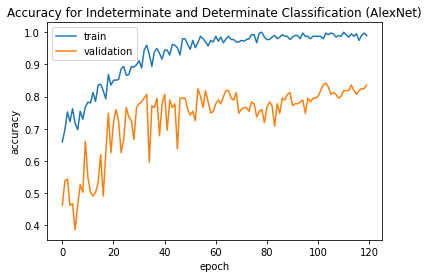

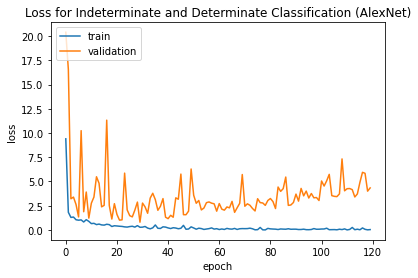

In [ ]:

#Deter_Indeter_AlexNet = keras.models.load_model('Deter_Indeter_AlexNet')
#os.chdir('/')
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy for Indeterminate and Determinate Classification (AlexNet)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Indeterminate and Determinate Classification (AlexNet).png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss for Indeterminate and Determinate Classification (AlexNet)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss for Indeterminate and Determinate Classification (AlexNet).png')
plt.show()

Evaluate on test data
6/6 [==============================] - 0s 28ms/step - loss: 4.8414 - accuracy: 0.8316
test loss, test acc: [4.841449737548828, 0.8315789699554443]
Generate predictions for 2 samples


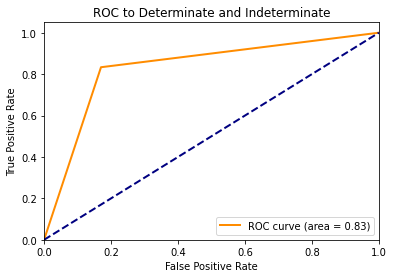

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = Deter_Indeter_AlexNet.evaluate(x_test, y_test)
print("test loss, test acc:", results)


# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions_DID = Deter_Indeter_AlexNet.predict(x_test, verbose = 0)


fpr, tpr, _ = roc_curve(np.argmax(y_test, axis=1), np.argmax(predictions_DID, axis=1))
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('ROC to Determinate and Indeterminate')
plt.legend(loc="lower right")
plt.savefig('determinate and indeterminate ROC curve (AlexNet Model).png')
plt.show()

The accuracy of the testing stage is 83.16% which is greater than 52.84% (=400/(357+400), 400 determinate samples and 357 indeterminate samples)

## **ResNet50**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
optim = 'rmsprop'
epochs = 100
batch_size = 60


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

Deter_Indeter_ResNet = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)


Deter_Indeter_ResNet.compile(optimizer = optim ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])


with tf.device('/GPU:0'):
    history_Deter_Indeter_ResNet = Deter_Indeter_ResNet.fit(x_train, y_train, validation_split=0.2,
                        epochs= epochs, batch_size= batch_size, verbose=2, 
                        callbacks=[learning_rate_reduction]
                       )

# Save the model
# os.chdir('/')
Deter_Indeter_ResNet.save('Deter_Indeter_ResNet')    

In [ ]:
np.save('determinate and indeterminate/history_Deter_Indeter_ResNet', history_Deter_Indeter_ResNet.history)
history=np.load('determinate and indeterminate/history_Deter_Indeter_ResNet.npy',allow_pickle='TRUE').item()

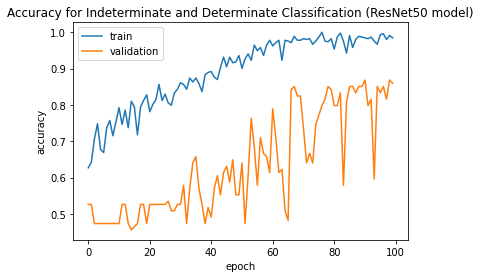

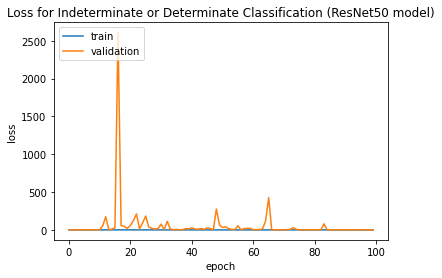

In [ ]:

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy for Indeterminate and Determinate Classification (ResNet50 model)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Indeterminate and Determinate Classification (ResNet50 model).png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss for Indeterminate or Determinate Classification (ResNet50 model)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss for Indeterminate or Determinate (ResNet50 model).png')
plt.show()



###**Model Evaluation**

In [ ]:
#Deter_Indeter_ResNet = keras.models.load_model('Deter_Indeter_ResNet')
print("Evaluate on test data")
results = Deter_Indeter_ResNet.evaluate(x_test, y_test)
print("test loss, test acc:", results)


# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions = Deter_Indeter_ResNet.predict(x_test, verbose = 1)


pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
print(pred)


m = keras.metrics.Accuracy()
m.update_state(y_true, pred)
print('Accuracy: ', m.result().numpy())


e = keras.metrics.MeanSquaredError()
e.update_state(y_true, pred)
e.result().numpy()
print('Error: ', e.result().numpy())



Evaluate on test data
6/6 [==============================] - 1s 128ms/step - loss: 1.1626 - accuracy: 0.8105
test loss, test acc: [1.1625571250915527, 0.8105263113975525]
Generate predictions for 2 samples
6/6 [==============================] - 2s 122ms/step
[1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0
 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0
 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1
 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1
 1 1 1 0 1]
Accuracy:  0.8105263
Error:  0.18947369


    The accuracy is 81.05%, much greater than 51%.

###**ROC**

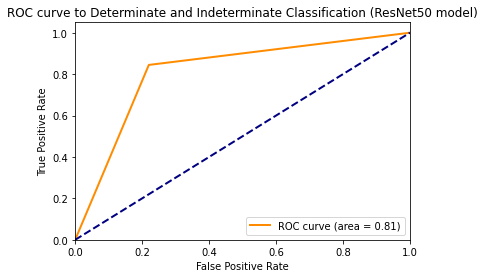

In [ ]:
fpr, tpr, _ = roc_curve(y_true, pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('ROC curve to Determinate and Indeterminate Classification (ResNet50 model)')
plt.legend(loc="lower right")
plt.savefig('ROC to Determinate and Indeterminate Classification (ResNet50 model).png')
plt.show()

## **Conclusion**


    In this part classfiying determinate and indeterminate skin lesion, AlexNet performs as much better as ResNet60. The accuracy of both models are out of 81%.

# **Step 3: Benign or Malignant**






**classifying an determinate mole into bengin skin lesion or malignant skin cancer. 0 is benign and 1 is malignant.**

## **Creating Corresponding Inputs and Outputs**

In [ ]:
variables = [benign, malignant]
Y_s = []
for i in range(len(variables)):
    myVars = globals()
    myVars['Y_'+str(i)] = np.repeat(i, len(variables[i]))
    Y_s.append(myVars['Y_'+str(i)])

**Data Merge**

In [ ]:
X = np.concatenate(variables, axis = 0)
Y = np.concatenate(Y_s, axis= 0) 
print(benign.shape)
print(malignant.shape)

(2345, 250, 250, 3)
(2207, 250, 250, 3)


**Shuffle data**


 75% of data as training data; 25% data as testing data.

In [ ]:
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=4, stratify=Y)

### **Display first 15 images of moles and their classifications**

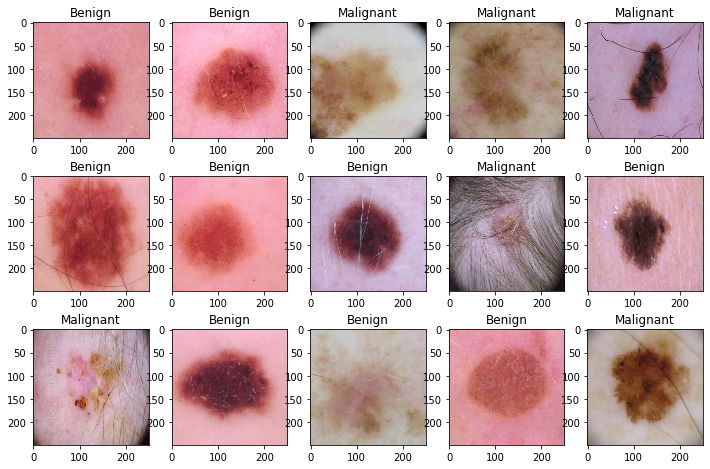

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)    
    if Y_train[i] ==0:
        ax.title.set_text('Benign')
    elif Y_train[i] ==1:
        ax.title.set_text('Malignant')          
    else:
        ax.title.set_text('Error')       
    plt.imshow(X_train[i], interpolation='nearest')
    plt.savefig('The fist 15 images of Benign or Malignant Step')
plt.show()

Some benign skin cancer as image in (1,4) is very similar to malignant skin cancer as image in (2,2).

**Categorical Labels and Normalization**

Turn labels into one hot encoding.

Normalize all Values of the pictures by dividing all the RGB values by 255\
With data augmentation to prevent overfitting 

In [ ]:
y_train = to_categorical(Y_train, num_classes= len(variables))
y_test = to_categorical(Y_test, num_classes= len(variables))
x_train = X_train/255.
x_test = X_test/255.

## **AlexNet**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
optim = 'rmsprop'
epochs = 100
batch_size = 70


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

BM_AlexNet = AlexNet(lr = lr, init = init, activ = activ, optim = optim, input_shape = input_shape)


with tf.device('/GPU:0'):
    history_BM_AlexNet = BM_AlexNet.fit(x_train, y_train, validation_split = 0.3,
                    epochs = epochs, batch_size = batch_size,verbose = 2, 
                   callbacks =[learning_rate_reduction])
    
# Save the model
# os.chdir('/')
BM_AlexNet.save('BM_AlexNet')  

In [ ]:
np.save('benign_malignant/history_BM_AlexNet', history_BM_AlexNet.history)
history=np.load('benign_malignant/history_BM_AlexNet.npy',allow_pickle='TRUE').item()

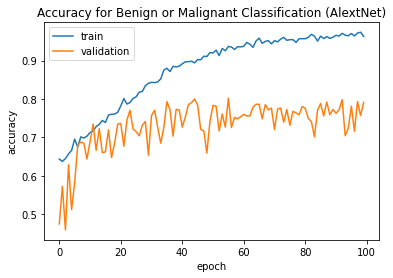

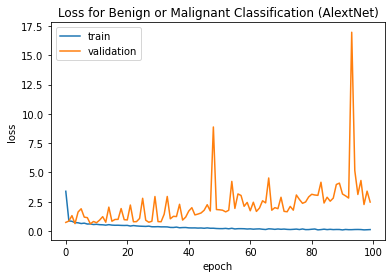

In [ ]:
#BM_AlexNet = keras.models.load_model('BM_AlexNet')
#os.chdir('/')
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy for Benign or Malignant Classification (AlextNet)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Benign or Malignant Classification (AlextNet).png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss for Benign or Malignant Classification (AlextNet)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss for Benign or Malignant Classification (AlextNet).png')
plt.show()

Evaluate on test data
36/36 [==============================] - 2s 27ms/step - loss: 2.6038 - accuracy: 0.7768
test loss, test acc: [2.60377836227417, 0.7768014073371887]
Generate predictions for 2 samples


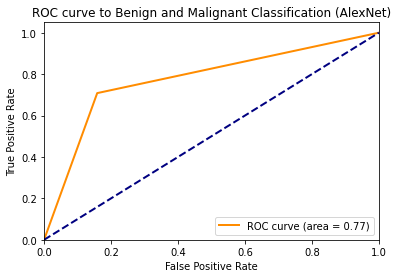

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = BM_AlexNet.evaluate(x_test, y_test)
print("test loss, test acc:", results)


# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions_BM = BM_AlexNet.predict(x_test, verbose = 0)


fpr, tpr, _ = roc_curve(np.argmax(y_test, axis=1), np.argmax(predictions_BM, axis=1))
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('ROC curve to Benign and Malignant Classification (AlexNet)')
plt.legend(loc="lower right")
plt.savefig('Benign or Malignant ROC curve (AlexNet).png')
plt.show()

### **Evaluations**

The accuracy of the testing stage is 77.68% 

which is greater than 51.52% (=2345/(2345+2207), 3973 benign samples and 3068 malignant samples)

## **ResNet50**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
optim = 'adam'
epochs = 120
batch_size = 70


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

BM_ResNet = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)


BM_ResNet.compile(optimizer = optim ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])


with tf.device('/GPU:0'):
    history_BM_ResNet = BM_ResNet.fit(x_train, y_train, validation_split=0.2,
                        epochs= epochs, batch_size= batch_size, verbose=2, 
                        callbacks=[learning_rate_reduction]
                       )

# Save the model
# os.chdir('/')
BM_ResNet.save('BM_ResNet')    

In [ ]:
np.save('benign_malignant/history_BM_ResNet', history_BM_ResNet.history)
history=np.load('benign_malignant/history_BM_ResNet.npy',allow_pickle='TRUE').item()

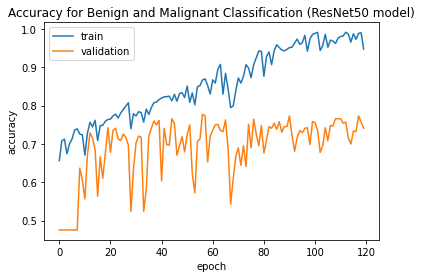

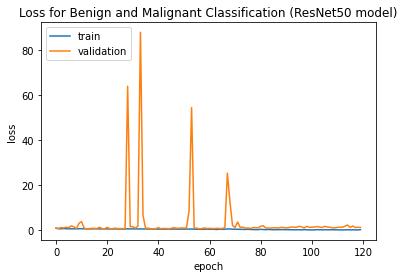

In [ ]:
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy for Benign and Malignant Classification (ResNet50 model)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Benign and Malignant Classification (ResNet50 model).png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss for Benign and Malignant Classification (ResNet50 model)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss for Benign and Malignant Classification (ResNet50 model).png')
plt.show()



### **Model Evaluation***

In [ ]:
#BM_ResNet = keras.models.load_model('BM_ResNet')
print("Evaluate on test data")
results = BM_ResNet.evaluate(x_test, y_test)
print("test loss, test acc:", results)


# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions = BM_ResNet.predict(x_test, verbose = 1)


pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
print(pred)


m = keras.metrics.Accuracy()
m.update_state(y_true, pred)
print('Accuracy: ', m.result().numpy())


e = keras.metrics.MeanSquaredError()
e.update_state(y_true, pred)
e.result().numpy()
print('Error: ', e.result().numpy())


Evaluate on test data
36/36 [==============================] - 6s 134ms/step - loss: 1.4158 - accuracy: 0.6872
test loss, test acc: [1.4158164262771606, 0.6871704459190369]
Generate predictions for 2 samples
36/36 [==============================] - 5s 116ms/step
[1 0 0 ... 0 0 1]
Accuracy:  0.68717045
Error:  0.31282952


    The accuracy is 68.72%, a little bit greater than 51.52%.

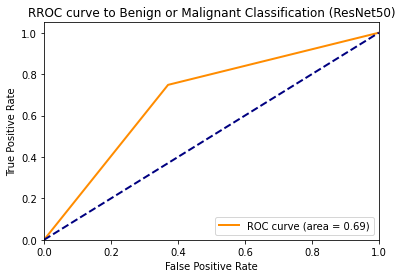

In [ ]:
fpr, tpr, _ = roc_curve(y_true, pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('RROC curve to Benign or Malignant Classification (ResNet50)')
plt.legend(loc="lower right")
plt.savefig('ROC Curve to Benign or Malignant (ResNet50).png')
plt.show()

## **Conclusion**


**In this part classfiying Benign and Malignant skin cancers, AlexNet performs well. The accuracy is 77% and the true positive prediction is 77%. Such that we use AlexNet in step 2.**

# **Step 4 - 1: for benign skin lesion, classifing keratosis, lentigo, nevus, dermatofibroma, and others**

**keratosis - 0, lentigo - 1, nevus - 2, dermatofibroma - 3, other benign skin lesions - 4**

## **Inputs and Outputs**

Images with size $250\times 250\times 3$, five kinds of labels to represent 5 categories of benign skin lesions.

In [ ]:
benign_variables = [keratosis, lentigo, nevus, dermatofibroma, neurofibroma]
Y_benign = []
for i in range(len(benign_variables)):
    myVars['Y_b'+str(i)] = np.repeat(i, len(benign_variables[i]))
    Y_benign.append(myVars['Y_b'+str(i)])

In [ ]:
X_benign = np.concatenate(benign_variables, axis = 0)
Y_benign = np.concatenate(Y_benign, axis= 0) 

s = np.arange(X_benign.shape[0])
np.random.shuffle(s)
X_benign = X_benign[s]
Y_benign = Y_benign[s]

X_benign_train, X_benign_test, Y_benign_train, Y_benign_test = train_test_split(X_benign, Y_benign, test_size=0.25, random_state=4, stratify=Y_benign)


### **Showing some Representatives**

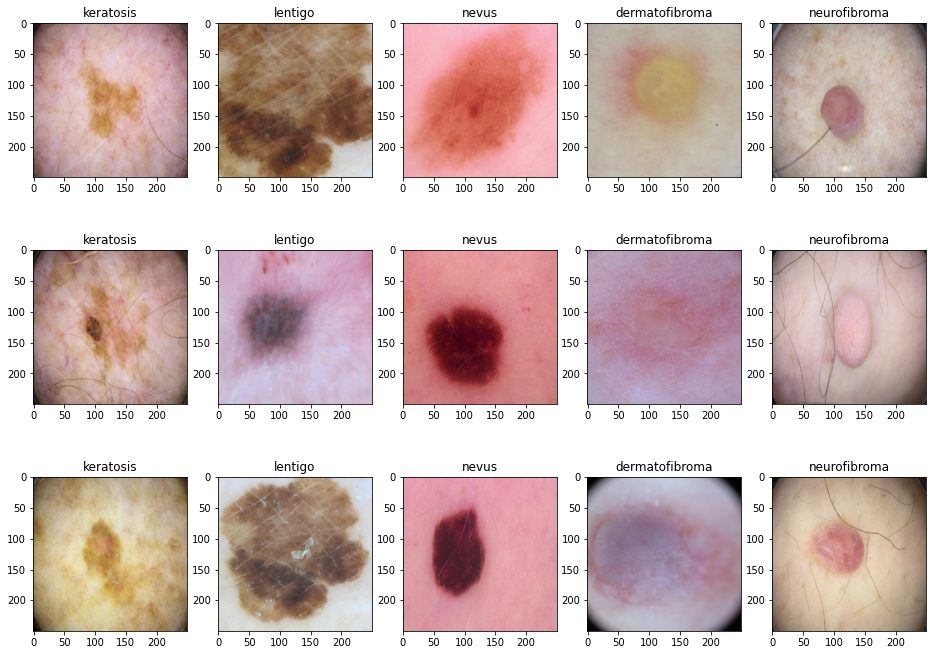

In [ ]:
w=60
h=60
fig=plt.figure(figsize=(16, 16))
columns = 5
rows = 4
t = 1
for i in [1,6,11]:
    t += 1
    ax = fig.add_subplot(rows, columns, i)    
    ax.title.set_text('keratosis')
    plt.imshow(keratosis[t], interpolation='antialiased') 
    ax = fig.add_subplot(rows, columns, i+1)    
    ax.title.set_text('lentigo')
    plt.imshow(lentigo[t], interpolation='antialiased') 
    ax = fig.add_subplot(rows, columns, i+2) 
    ax.title.set_text('nevus')
    plt.imshow(nevus[t], interpolation='antialiased') 
    ax = fig.add_subplot(rows, columns, i+3) 
    ax.title.set_text('dermatofibroma')
    plt.imshow(dermatofibroma[t], interpolation='antialiased') 
    ax = fig.add_subplot(rows, columns, i+4) 
    ax.title.set_text('others')
    plt.imshow(neurofibroma[t], interpolation='antialiased') 
plt.savefig('representatives of benign skin lesions')    
plt.show()

In [ ]:
y_benign_train = to_categorical(Y_benign_train, num_classes= len(benign_variables))
y_benign_test = to_categorical(Y_benign_test, num_classes= len(benign_variables))
x_benign_train = X_benign_train/255.
x_benign_test = X_benign_test/255.

## **ResNet60**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
optim = 'rmsprop'
epochs = 80
batch_size = 40
num_class = len(benign_vars)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=2, 
                                            factor=0.5, 
                                            min_lr=1e-7)

benign_ResNet = MobileNet(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=5)

benign_ResNet.compile(optimizer = optim ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history_benign_ResNet = benign_ResNet.fit(x_benign_train, y_benign_train, validation_split=0.25,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# Save the model
# os.chdir('/')
benign_ResNet.save('benign_ResNet')

In [ ]:
np.save('benign/history_benign_ResNet', history_benign_ResNet.history)
history=np.load('benign/history_benign_ResNet.npy',allow_pickle='TRUE').item()

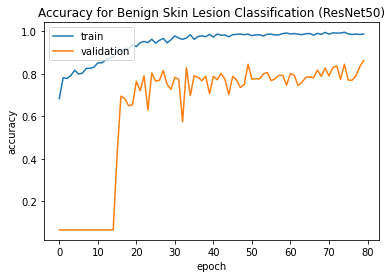

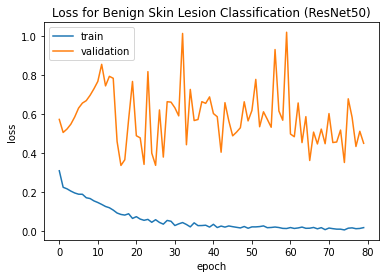

In [ ]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy for Benign Skin Lesion Classification (ResNet50)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Benign Skin Lesion Classification (ResNet50).png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss for Benign Skin Lesion Classification (ResNet50)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss for Benign Skin Lesion Classification (ResNet50).png')
plt.show()

In [ ]:
# benign_ResNet = keras.models.load_model('benign_ResNet')
print("Evaluate on test data")
results = benign_ResNet.evaluate(x_benign_test, y_benign_test)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
pred_benign = benign_ResNet.predict(x_benign_test, verbose = 0)
prediction_benign = np.argmax(pred_benign, axis=1)
# print('The prediction is: ', prediction_benign)



Evaluate on test data
19/19 [==============================] - 2s 56ms/step - loss: 0.5797 - accuracy: 0.8160
test loss, test acc: [0.5796520113945007, 0.8160136342048645]
Generate predictions for 2 samples
19/19 [==============================] - 1s 40ms/step


### **Evaluations**

    The accuracy of testing is 81.6%, but as we can see, the accuracy of validation is slowly growing up as the number of epoches increases. 603 keratosis, 85 lentigo, 1516 nevus, 135 dermatofibroma, 6, neurofibroma

## **DenseNet121**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
epochs = 80
batch_size = 40
optim = 'rmsprop'

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

benign_DenseNet = keras.applications.densenet.DenseNet121(
    include_top=True,
    weights= None,
    input_tensor=None,
    input_shape=input_shape,
    pooling='avg',
    classes=5,
    classifier_activation='softmax')

benign_DenseNet.compile(optimizer = optim ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

with tf.device('/GPU:0'):
  history_benign_DenseNet = benign_DenseNet.fit(x_benign_train, y_benign_train, validation_split=0.3,
                      epochs= epochs, batch_size= batch_size, verbose=2, 
                      callbacks=[learning_rate_reduction])
  
# Save the model
# os.chdir('/')
benign_DenseNet.save('benign_DenseNet') 

In [ ]:
np.save('benign/history_benign_DenseNet', history_benign_DenseNet.history)
history=np.load('benign/history_benign_DenseNet.npy',allow_pickle='TRUE').item()

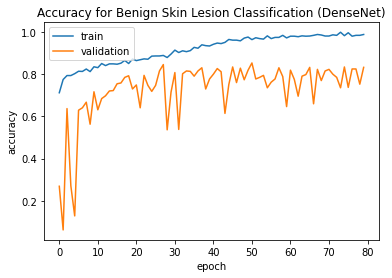

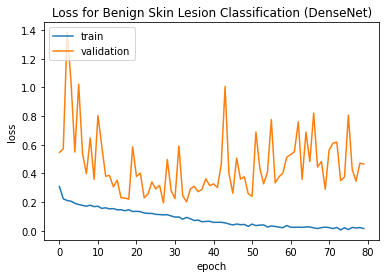

In [ ]:
# summarize history for accuracy
plt.plot(history_benign_DenseNet.history['accuracy'])
plt.plot(history_benign_DenseNet.history['val_accuracy'])
plt.title('Accuracy for Benign Skin Lesion Classification (DenseNet)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Benign Skin Lesion Classification (DenseNet).png')
plt.show()


# summarize history for loss
plt.plot(history_benign_DenseNet.history['loss'])
plt.plot(history_benign_DenseNet.history['val_loss'])
plt.title('Loss for Benign Skin Lesion Classification (DenseNet)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss for Benign Classification Skin Lesion (DenseNet).png')
plt.show()



In [ ]:
#benign_DenseNet = keras.models.load_model('benign_DenseNet')
print("Evaluate on test data")
results = benign_DenseNet.evaluate(x_benign_test, y_benign_test)
print("test loss, test acc:", results)

Evaluate on test data
19/19 [==============================] - 5s 168ms/step - loss: 0.5381 - accuracy: 0.8194
test loss, test acc: [0.5380910038948059, 0.8194207549095154]


### **Evaluations**

    The testing accuracy of DenseNet is 81.94% close to the accuracy of ResNet. The DenseNet model can quickly find a local optimal, but it has overfiting problem, since after the 80 epoch, the loss of validation grows up continously.  

## **Conclusion**


**ResNet and DenseNet's performances in accuracy are close to 80%**

# **Step 4-2: For skin cancer, classifying melanoma, basal cell carcinoma, and squamous cell carcinoma**


**melanoma - 0, basal_cell_carcinoma - 1, squamous_cell_carcinoma - 2**



## **Data for Training**

In [ ]:
malignant_variables = [melanoma, basal_cell_carcinoma, squamous_cell_carcinoma]
Y_malignant = []
myVars = globals()
for i in range(len(malignant_variables)):
    myVars['Y_'+str(i)] = np.repeat(i, len(malignant_variables[i]))
    Y_malignant.append(myVars['Y_'+str(i)])

In [ ]:
X_malignant = np.concatenate(malignant_variables, axis = 0)
Y_malignant = np.concatenate(Y_malignant, axis= 0) 

s = np.arange(X_malignant.shape[0])
np.random.shuffle(s)
X_malignant = X_malignant[s]
Y_malignant = Y_malignant[s]

X_malignant_train, X_malignant_test, Y_malignant_train, Y_malignant_test = train_test_split(X_malignant, Y_malignant, test_size=0.25, random_state=1, stratify=Y_malignant)


### **Representatives**

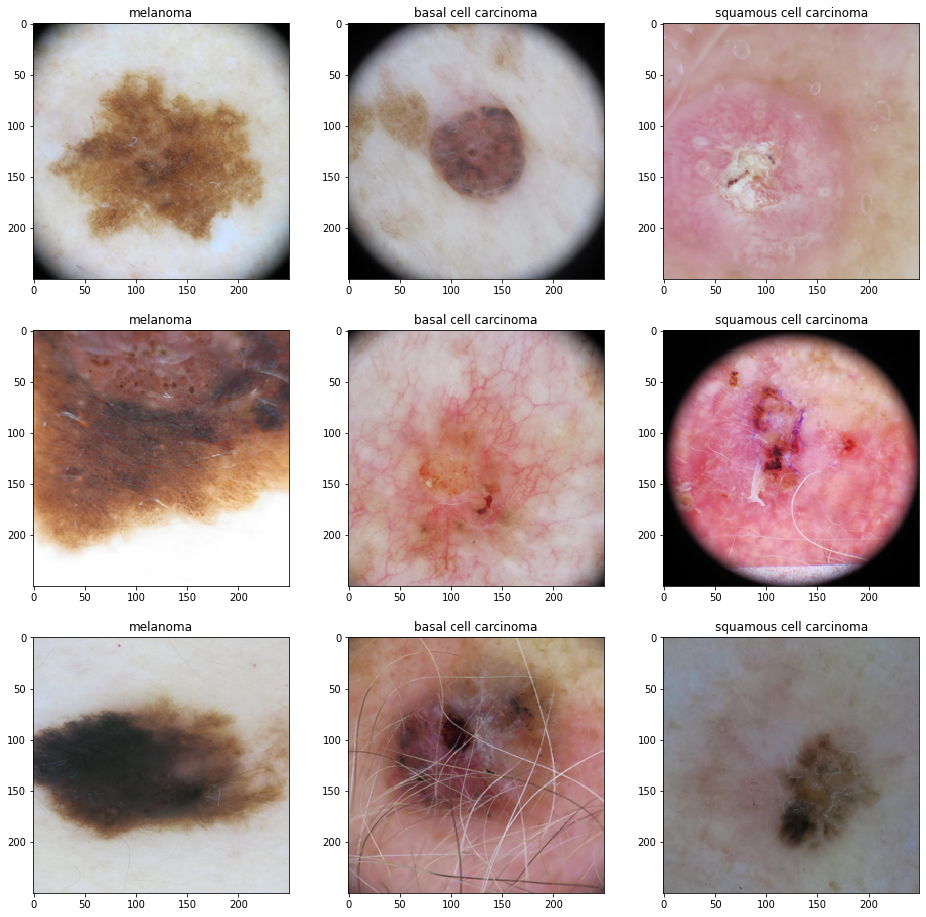

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(16, 16))
columns = 3
rows = 3


for i in [1,4,7]:
    ax = fig.add_subplot(rows, columns, i)    
    ax.title.set_text('melanoma')
    plt.imshow(melanoma[i+4], interpolation='nearest') 

    ax = fig.add_subplot(rows, columns, i+1)    
    ax.title.set_text('basal cell carcinoma') 
    plt.imshow(basal_cell_carcinoma[i+6], interpolation='nearest') 

    ax = fig.add_subplot(rows, columns, i+2)    
    ax.title.set_text('squamous cell carcinoma') 
    plt.imshow(squamous_cell_carcinoma[i+3], interpolation='nearest')     
plt.savefig('representatives of malignant skin cancer')    
plt.show()


    Melanoma looks much darker than basal cell carcinoma.

In [ ]:
y_malignant_train = to_categorical(Y_malignant_train, num_classes= len(malignant_variables))
y_malignant_test = to_categorical(Y_malignant_test, num_classes= len(malignant_variables))
x_malignant_train = X_malignant_train/255.
x_malignant_test = X_malignant_test/255.

## **ResNet50**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
optim = 'rmsprop'
epochs = 80
batch_size = 70


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

malignant_ResNet = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=3)

malignant_ResNet.compile(optimizer = optim ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

with tf.device('/GPU:0'):
  history_malignant_ResNet = malignant_ResNet.fit(x_malignant_train, y_malignant_train, validation_split=0.2,
                      epochs= epochs, batch_size= batch_size, verbose=2, 
                      callbacks=[learning_rate_reduction]
                    )
  
# Save the model
# os.chdir('/')
malignant_ResNet.save('malignant_ResNet')  

In [ ]:
np.save('malignant/history_malignant_ResNet', history_malignant_ResNet.history)
history=np.load('malignant/history_malignant_ResNet.npy',allow_pickle='TRUE').item()

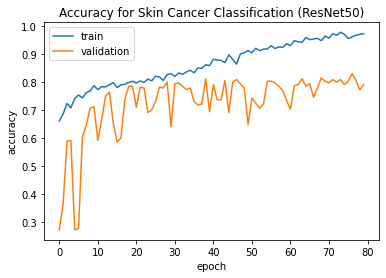

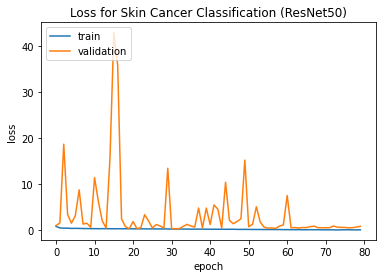

In [ ]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy for Skin Cancer Classification (ResNet50)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Skin Cancer Classification ResNet50.png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss for Skin Cancer Classification (ResNet50)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss for Skin Cancer Classification ResNet50.png')
plt.show()

In [ ]:
#malignant_ResNet = keras.models.load_model('malignant_ResNet')
print("Evaluate on test data")
results = malignant_ResNet.evaluate(x_malignant_test, y_malignant_test)
print("test loss, test acc:", results)


# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions_malignant = malignant_ResNet.predict(x_malignant_test, verbose = 1)


# np.argmax(model.predict(x_train, verbose = 1), axis = 1)

Evaluate on test data
18/18 [==============================] - 1s 38ms/step - loss: 1.1321 - accuracy: 0.7518
test loss, test acc: [1.132085919380188, 0.7518116235733032]
Generate predictions for 2 samples
18/18 [==============================] - 1s 25ms/step


### **Evaluations**

    The accuracy is 75.18%, which is pretty high, with respect to the proporton of melanoma in inputs - 59.45% = 1312/(1312+318+577)%.


## **VGG19**

In [ ]:
input_shape = (250,250,3)
lr = 1e-2
init = 'glorot_uniform'
activ = 'relu'
epochs = 100
batch_size = 15
optim = 'SGD'

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)


malignant_VGG = keras.applications.vgg19.VGG19(
    include_top=True,
    weights= None,
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=3,
    classifier_activation='softmax')

malignant_VGG.compile(optimizer = optim ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

with tf.device('/GPU:0'):
  history_malignant_VGG= malignant_VGG.fit(x_malignant_train, y_malignant_train, validation_split=0.3,
                      epochs= epochs, batch_size= batch_size, verbose=2, 
                      callbacks=[learning_rate_reduction])
  
# Save the model
# os.chdir('/')
malignant_VGG.save('malignant_VGG')  

In [ ]:
np.save('malignant/history_malignant_VGG', history_malignant_VGG.history)
history=np.load('malignant/history_malignant_VGG.npy',allow_pickle='TRUE').item()

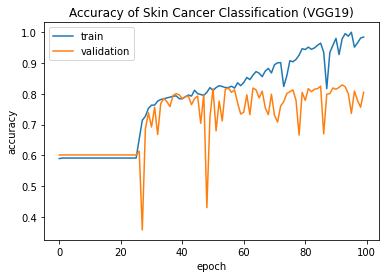

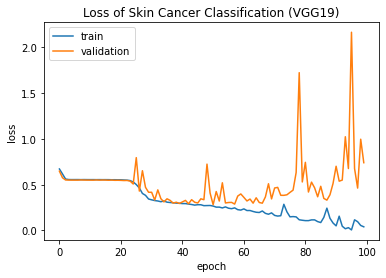

In [ ]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy of Skin Cancer Classification (VGG19)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy of Skin Cancer Classification (VGG19).png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss of Skin Cancer Classification (VGG19)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss of Skin Cancer Classification (VGG19).png')
plt.show()

In [ ]:
# malignant_VGG = keras.models.load_model('malignant_VGG') 

print("Evaluate on test data")
results = malignant_VGG.evaluate(x_malignant_test, y_malignant_test)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions_malignant = malignant_VGG.predict(x_malignant_test, verbose = 1)


Evaluate on test data
18/18 [==============================] - 2s 51ms/step - loss: 0.7238 - accuracy: 0.7880
test loss, test acc: [0.7238072752952576, 0.7880434989929199]
Generate predictions for 2 samples
18/18 [==============================] - 1s 34ms/step


### **Evaluations**

    The accuracy is 78.8%, which is pretty high, with respect to the proporton of melanoma in inputs - 59.45% = 1312/(1312+318+577)%.


## **Conclusion**



As we can see, given a small sample size, the complicated CNNs (like AlexNet and ModelNet) and the too simple CNN (like Simplebuild model) could not help to improve the accuracy of testing and true positive prediction. The reasons mightbe that:

(1) complicated CNNs (with many parameters) can easily find and stuck at the Local Optimal state -- always guessing 'determiate'.

(2) the sample size is too small to a simple CNN to find the robust features between indeterminate and determinate moles. 

(3) There is no robust features between indeterminate and determinate moles even given a large sample size.


Overall, we choose the Build Neural Network, since it offers a true positive prediction at some degree, although the accuracy of prediction is low. Luckily, the indeterminate moles and lesions mainly consist of nevus, atypical melanocytic proliferation (AMP), and AIMP (AMP and AIMP are lesions sharing some features with melanoma but failing to meet criteria of a definitive benign or malignant diagnosis), so taking a skin lesion with an indeterminate diagnosis (as determinate) to step 2 would not bring us trouble, since datasets for the second step consist of nevus and melanoma.

# **Step 4-3 For Indeterminate Skin Lesion, classifying Actinic Keratosis, Vascular Lesion, and others (including Atypical Melanocytic Proliferation (AMP), AIMP)**

**actinic keratosis - 0, vascular lesion - 1, and others - 3**.

## **Training Data**

In [ ]:
variables = [actinic_keratosis,  vascular_lesion, others]
Y_s = []
for i in range(len(variables)):
    myVars = globals()
    myVars['Y_'+str(i)] = np.repeat(i, len(variables[i]))
    Y_s.append(myVars['Y_'+str(i)])

**0 is actinic keratosis, 1 is vascular lesion, and 2 is others in Y; [1,0,0] is actinic keratosis, [0,1,0] is vascular lesion, and [0,0,1] in y**.

In [ ]:
X = np.concatenate(variables, axis = 0)
Y = np.concatenate(Y_s, axis= 0) 

**Shuffle data**


 75% of data as training data; 25% data as testing data.

In [ ]:
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=4, stratify=Y)

### **Display Representatives**

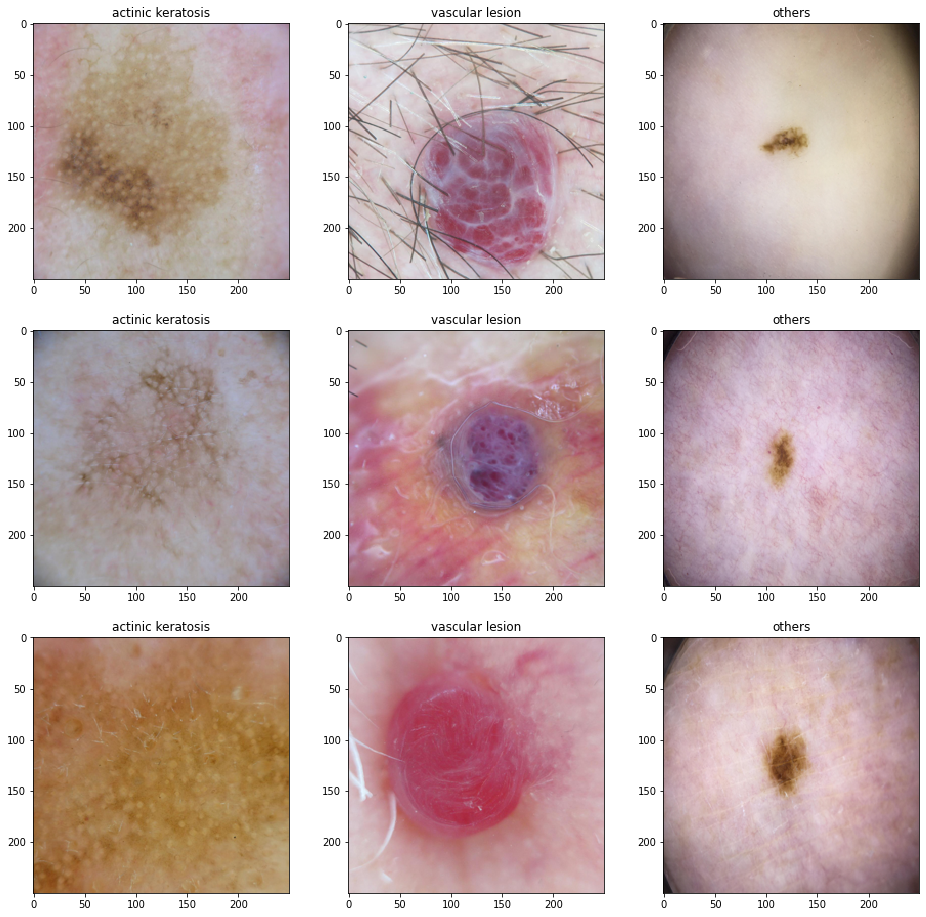

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(16, 16))
columns = 3
rows = 3

for i in [1,4,7]:
    ax = fig.add_subplot(rows, columns, i)    
    ax.title.set_text('actinic keratosis')
    plt.imshow(actinic_keratosis[i+3], interpolation='nearest') 

    ax = fig.add_subplot(rows, columns, i+1)    
    ax.title.set_text('vascular lesion') 
    plt.imshow(vascular_lesion[i+6], interpolation='nearest') 

    ax = fig.add_subplot(rows, columns, i+2)    
    ax.title.set_text('others') 
    plt.imshow(others[i+3], interpolation='nearest')     
plt.savefig('representatives of indeterminate skin lesion')    
plt.show()

**Categorical Labels and Normalization**

Turn labels into one hot encoding.

Normalize all Values of the pictures by dividing all the RGB values by 255\
With data augmentation to prevent overfitting 

In [ ]:
y_train = to_categorical(Y_train, num_classes= len(variables))
y_test = to_categorical(Y_test, num_classes= len(variables))
x_train = X_train/255.
x_test = X_test/255.

## **AlexNet**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
optim = 'rmsprop'
epochs = 200
batch_size = 35


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

indeterminate_AlexNet = AlexNet(lr = lr, init = init, activ = activ, optim = optim, input_shape = input_shape, num_classes = 3)


with tf.device('/GPU:0'):
    history_indeterminate_AlexNet = indeterminate_AlexNet.fit(x_train, y_train, validation_split = 0.25,
                    epochs = epochs, batch_size = batch_size,verbose = 2, 
                   callbacks =[learning_rate_reduction])
    
# Save the model
# os.chdir('/')
indeterminate_AlexNet.save('indeterminate_AlexNet')  

In [ ]:
np.save('indeterminate/history_indeterminate_AlexNet', history_indeterminate_AlexNet.history)
history=np.load('indeterminate/history_indeterminate_AlexNet.npy',allow_pickle='TRUE').item()

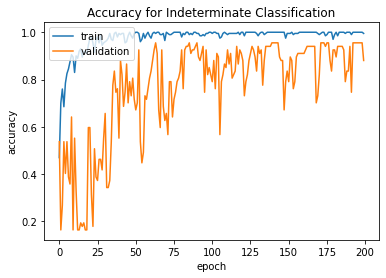

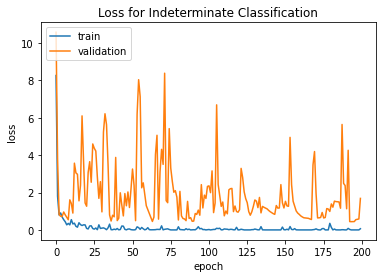

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy for Indeterminate Classification (AlexNet)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Indeterminate Classification (AlexNet).png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss for Indeterminate Classification (AlexNet)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss for Indeterminate Classification (AlexNet).png')
plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = indeterminate_AlexNet.evaluate(x_test, y_test)
print("test loss, test acc:", results)


Evaluate on test data
3/3 [==============================] - 1s 284ms/step - loss: 2.3883 - accuracy: 0.8667
test loss, test acc: [2.3882713317871094, 0.8666666746139526]


In [ ]:
print(actinic_keratosis.shape)
print(vascular_lesion.shape)
print(others.shape)

(86, 250, 250, 3)
(199, 250, 250, 3)
(72, 250, 250, 3)


### **Evaluations**

    the accuracy of the indeterminate classification is 86.67% much higher than naive guess 55.74% =  199/(86+199+72)

## **ResNet101V2**

In [ ]:
input_shape = (250,250,3)
lr = 1e-3
init = 'glorot_uniform'
activ = 'relu'
epochs = 100
batch_size = 30
optim = 'adam'

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)



indeterminate_ResNet101V2 = keras.applications.densenet.DenseNet201(
    include_top=True,
    weights= None,
    input_tensor=None,
    input_shape=input_shape,
    pooling='max',
    classes=3,
   classifier_activation='softmax')



indeterminate_ResNet101V2.compile(optimizer = optim ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])


with tf.device('/GPU:0'):
  history_indeterminate_ResNet101V2 = indeterminate_ResNet101V2.fit(x_train, y_train, validation_split=0.3,
                      epochs= epochs, batch_size= batch_size, verbose=2, 
                      callbacks=[learning_rate_reduction])
  
# Save the model
# os.chdir('/')
indeterminate_ResNet101V2.save('indeterminate_ResNet101V2')  

In [ ]:
np.save('indeterminate/history_indeterminate_ResNet101V2', history_indeterminate_ResNet101V2.history)
history=np.load('indeterminate/history_indeterminate_ResNet101V2.npy',allow_pickle='TRUE').item()

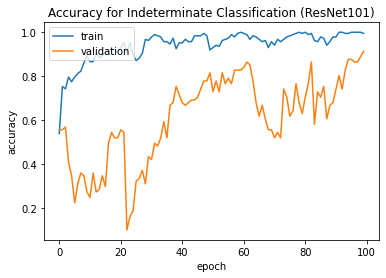

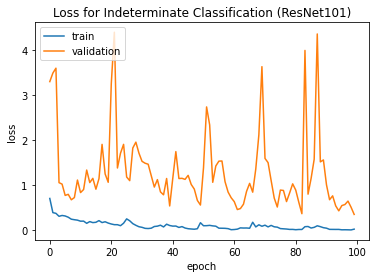

In [ ]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy for Indeterminate Classification (ResNet101)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Accuracy for Indeterminate Classification (ResNet101).png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss for Indeterminate Classification (ResNet101)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss for Indeterminate Classification (ResNet101).png')
plt.show()

In [ ]:
# indeterminate_ResNet101V2 = keras.models.load_model('indeterminate_ResNet101V2') 

print("Evaluate on test data")
results = indeterminate_ResNet101V2.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions = indeterminate_ResNet101V2.predict(x_test, verbose = 1)


Evaluate on test data
3/3 [==============================] - 1s 157ms/step - loss: 0.2003 - accuracy: 0.9333
test loss, test acc: [0.20034056901931763, 0.9333333373069763]
Generate predictions for 2 samples
3/3 [==============================] - 0s 160ms/step


### **Evaluations**

    the accuracy of the indeterminate classification is 93.33% much higher than naive guess 55.74% =  199/(86+199+72)

# **Demo**

In [ ]:
size = (250, 250)
read = lambda imname: np.asarray(Image.open(imname).resize(size).convert("RGB"))

path_demo  = 'Demo/'
demo = []
for filename in os.listdir(path_demo):
   if filename[-3:] == 'JPG':
     demo.append(read(os.path.join(path_demo, filename)))
     print(filename)
demo  = np.array(demo,  dtype='uint8')/255

vascular_lesion.JPG
melanoma.JPG
nevus.JPG
invalid1.JPG
invalid2.JPG


**Step 1**

In [ ]:
firststep = keras.models.load_model('Valid_Invalid_ResNet')

print(np.argmax(firststep.predict(demo, verbose = 1), axis=1))

#np.argmax(model_build.predict(x_in_det_test, verbose = 0), axis=1)

1/1 [==============================] - 1s 1s/step
[1 1 1 0 0]


**invalid - 0 ; valid - 1**

**Step 2**

In [ ]:
secondstep = keras.models.load_model('Deter_Indeter_ResNet')

print(np.argmax(secondstep.predict(demo[0:3,], verbose = 1), axis=1))

#np.argmax(model_build.predict(x_in_det_test, verbose = 0), axis=1)

1/1 [==============================] - 1s 1s/step
[1 0 0]


**determinate - 0 ; indeterminate - 1**

**step 3**

In [ ]:
thirdstep = keras.models.load_model('BM_ResNet')

print(np.argmax(thirdstep.predict(demo[1:3,], verbose = 1), axis=1))

1/1 [==============================] - 1s 1s/step
[1 0]


**benign - 0 ; malignant - 1**

**step4-1**

In [ ]:
fourth_one = keras.models.load_model('benign_DenseNet')

print(np.argmax(fourth_one.predict(demo[2:3,], verbose = 1), axis=1))

1/1 [==============================] - 3s 3s/step
[2]


**keratosis - 0, lentigo - 1, nevus - 2, dermatofibroma - 3, other benign skin lesions - 4**



**step4-2**

In [ ]:
fourth_two = keras.models.load_model('malignant_VGG')

print(np.argmax(fourth_two.predict(demo[1:2,], verbose = 1), axis=1))

1/1 [==============================] - 1s 916ms/step
[0]


**melanoma - 0, basal_cell_carcinoma - 1, squamous_cell_carcinoma - 2**



**step 4-3**

In [ ]:
fourth_three = keras.models.load_model('indeterminate_ResNet101V2')

print(np.argmax(fourth_three.predict(demo[0:1,], verbose = 1), axis=1))

1/1 [==============================] - 4s 4s/step
[1]


**actinic keratosis - 0, vascular lesion - 1, and others - 3**.